In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from random import randint
from matplotlib import pyplot as plt

In [2]:
import datetime
from common import get_full_data
# load data
def steel_strength():
    df = pd.read_csv("dataset/steel_strength.csv")
    # get dependent and independent features
    X=df.iloc[:,1:-3]
    y=df.iloc[:,-2]
    return get_full_data(X,y)

def renewable():
    df = pd.read_csv("dataset/Renewable.csv")
    time = df["Time"].apply(lambda x: datetime.datetime.fromisoformat(x))
    df=df.drop(columns=["Time"])
    df["month"] = time.apply(lambda t: t.month)
    df["day"] = time.apply(lambda t: t.day)
    df["hour"] = time.apply(lambda t: t.hour)
    df["minute"] = time.apply(lambda t: t.minute)
    return df.iloc[:,1:], df.iloc[:,0]

In [3]:
from xgboost import XGBRegressor
X,y = steel_strength()

# for high-dimensional data use `gpu` for device if you have one
special_model = XGBRegressor(device='cpu')

In [4]:
from sklearn.decomposition import PCA

from render import plot_3d_rgb, plot_2d_rgb

pca = PCA(n_components=3)
X_small = pca.fit_transform(X)
y_n = y.to_numpy()[:,np.newaxis]

X_small=np.concatenate([X_small,y_n],axis=1)
print(sum(pca.explained_variance_ratio_))
np.random.shuffle(X_small)
plot_2d_rgb(X_small[:10000],"render",["d1","d2","d3"])

0.9624731257052234


In [5]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from common import XGB_search_params

params = XGB_search_params()
state = randint(0,1000)
search = RandomizedSearchCV(
    special_model,
    params,
    n_iter=250,
    cv=5,
    random_state=state,
    n_jobs=-1,
)

# amount of samples used for parameters search
search_space_samples=5000

if search_space_samples>=len(X):
    search_space_samples=len(X)-1

_,X_search,_,y_search = train_test_split(X,y,test_size=search_space_samples/len(X))

search.fit(X_search,y_search)
special_model=search.best_estimator_

In [6]:
# do repeated stratified k-fold cross-validation with classification report
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, cross_val_score
from common import cross_val_score_mean_std

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=50)
r2_scoring = metrics.make_scorer(metrics.r2_score)
print("r2 scoring")
cross_val_score_mean_std(cross_val_score(special_model,X,y,cv=cv,scoring=r2_scoring),y.name)

r2 scoring
-----------tensile strength-----------
Mean  0.8276899125391474
Std  0.11135361930215094


Evaluate score  17728.337075451


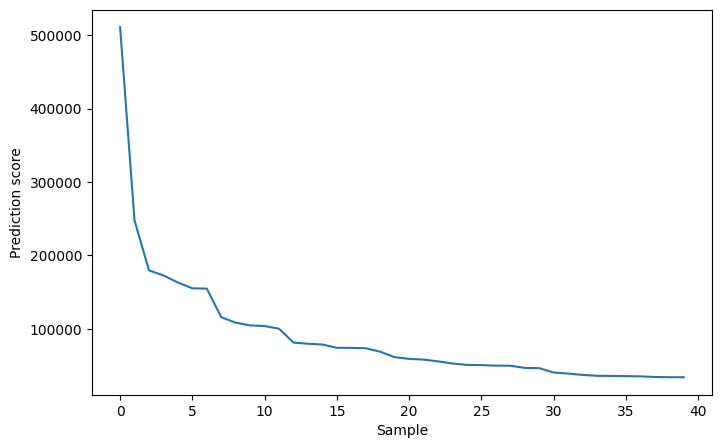

Evaluate score  13311.834405730731


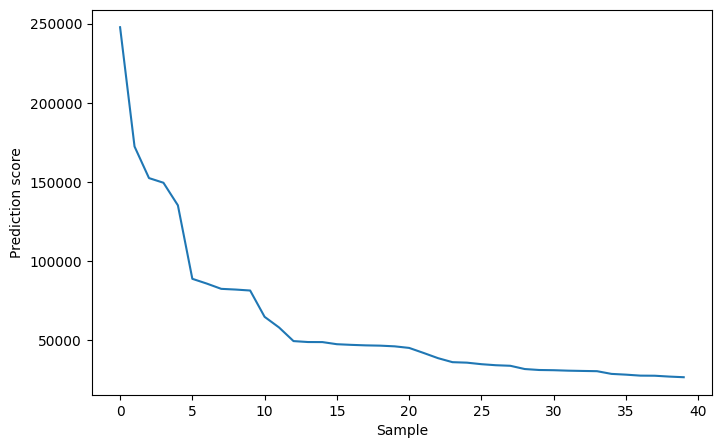

Evaluate score  10947.084661179635


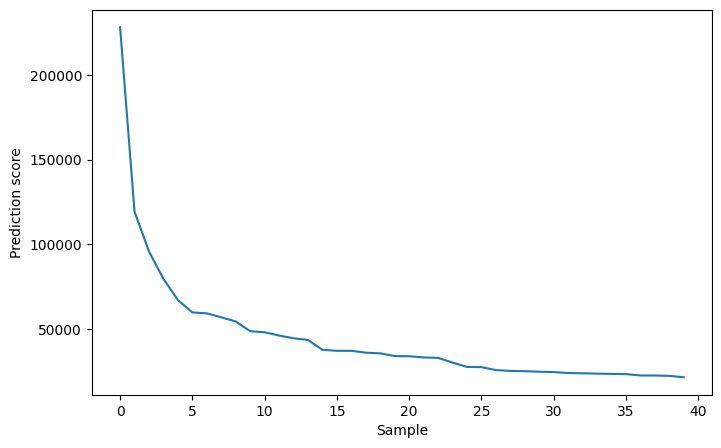

Evaluate score  9401.417381207148


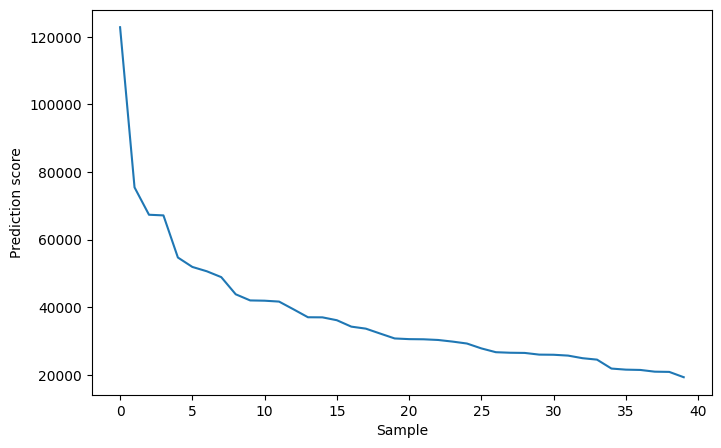

Evaluate score  9356.099471509046


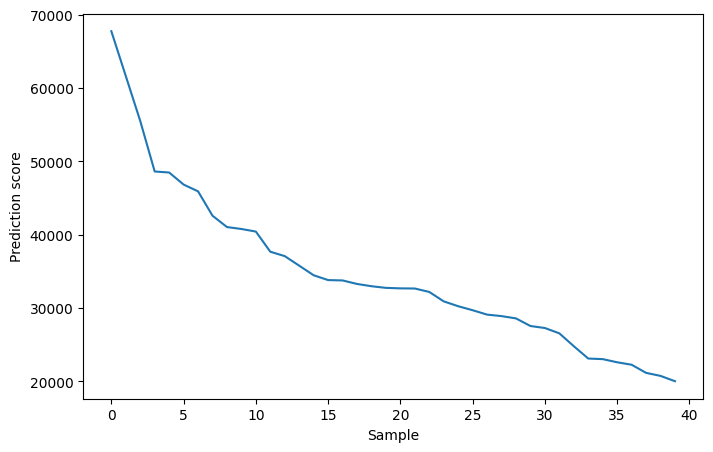

removed  0.09935897435897435
r2 score
-----------tensile strength-----------
Mean  0.9155175387981428
Std  0.015569730417928893


In [8]:
# New method
from common import find_outliers
X_numpy = X.to_numpy()
y_numpy = y.to_numpy()

outliers_mask, score = find_outliers(
    X_numpy,
    y_numpy,
    special_model,
    outliers_to_remove=0.1,
    iterations=5,
    gamma=0.5,
    evaluate_loss=metrics.mean_squared_error,
    cv=5,
    repeats=3,
    plot=True
)
print("removed ",np.sum(outliers_mask)/len(y))
X_clean = X_numpy[~outliers_mask]
y_clean = y_numpy[~outliers_mask]

r2_scoring = metrics.make_scorer(metrics.r2_score)
print("r2 score")
cross_val_score_mean_std(cross_val_score(special_model,X_clean,y_clean,cv=cv,scoring=r2_scoring),y.name)


In [ ]:
X_small = pca.transform(X_clean)
y_n = np.array(y_clean)[:,np.newaxis]

X_small=np.concatenate([X_small,y_n],axis=1)
np.random.shuffle(X_small)
plot_3d_rgb(X_small[:10000],"render",["d1","d2","d3"])

In [ ]:
# z-score method
from scipy import stats
data = pd.concat([X,y],axis=1)
z = np.abs(stats.zscore(data))
threshold = 3
data_clean = data[(z < threshold).all(axis=1)]

X_clean=data_clean.iloc[:,:-2]
y_clean=data_clean.iloc[:,-1]

r2_scoring = metrics.make_scorer(metrics.r2_score)
print("r2 score")
cross_val_score_mean_std(cross_val_score(special_model,X_clean,y_clean,cv=cv,scoring=r2_scoring),y.name)

In [ ]:

import pandas as pd

# Assuming 'data' is a Pandas DataFrame
Q1 = data.quantile(0.05)
Q3 = data.quantile(0.95)
IQR = Q3 - Q1
data_clean = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

X_clean=data_clean.iloc[:,:-2]
y_clean=data_clean.iloc[:,-1]

r2_scoring = metrics.make_scorer(metrics.r2_score)
cross_val_score_mean_std(cross_val_score(special_model,X_clean,y_clean,cv=cv,scoring=r2_scoring),y.name)

In [ ]:
from sklearn.ensemble import IsolationForest


clf = IsolationForest(random_state=50)
outliers_pred=clf.fit_predict(data)

data_clean = data[outliers_pred==1]

X_clean=data_clean.iloc[:,:-2]
y_clean=data_clean.iloc[:,-1]

r2_scoring = metrics.make_scorer(metrics.r2_score)
cross_val_score_mean_std(cross_val_score(special_model,X_clean,y_clean,cv=cv,scoring=r2_scoring),y.name)

Compare performance with some control model `KernelRidge` with `rbf` kernel and standard scaler

do parameters search for it using `RandomSearchCV`